<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
ls

drive/  sample_data/


# Single file

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
import librosa
x, sr = librosa.load('/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
print(x.shape)
print(sr)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(data=x, rate=sr)

In [ ]:
single_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(single_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
single_mfcc

# Whole Dataset (1440 files)

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split



Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [3]:
audio = "/content/drive/My Drive/audio/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [ ]:
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

In [ ]:
audio

In [4]:
# audio/audio/audio_speech_actors_01-24/Actor_14
# 03-01-02-01-02-01-14.wav

emotion = []
gender = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [5]:
os.listdir(audio + i)

['03-01-06-01-02-02-24.wav',
 '03-01-04-01-02-02-24.wav',
 '03-01-03-02-02-01-24.wav',
 '03-01-06-01-02-01-24.wav',
 '03-01-04-01-01-02-24.wav',
 '03-01-05-02-02-02-24.wav',
 '03-01-04-02-02-01-24.wav',
 '03-01-01-01-01-02-24.wav',
 '03-01-05-02-01-01-24.wav',
 '03-01-06-02-02-01-24.wav',
 '03-01-04-01-01-01-24.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-05-01-02-02-24.wav',
 '03-01-02-01-02-02-24.wav',
 '03-01-02-02-01-02-24.wav',
 '03-01-07-01-02-01-24.wav',
 '03-01-06-01-01-01-24.wav',
 '03-01-03-01-01-02-24.wav',
 '03-01-03-01-01-01-24.wav',
 '03-01-04-01-02-01-24.wav',
 '03-01-07-01-01-01-24.wav',
 '03-01-06-01-01-02-24.wav',
 '03-01-02-02-01-01-24.wav',
 '03-01-02-01-02-01-24.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-04-02-01-01-24.wav',
 '03-01-05-01-01-02-24.wav',
 '03-01-04-02-01-02-24.wav',
 '03-01-03-02-02-02-24.wav',
 '03-01-04-02-02-02-24.wav',
 '03-01-03-02-01-02-24.wav',
 '03-01-05-01-01-01-24.wav',
 '03-01-06-02-01-02-24.wav',
 '03-01-02-02-02-02-24.wav',
 '03-01-01-01-

In [7]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
audio_df.columns = ['gender','emotion']
audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
audio_df.labels.value_counts()

male_fear          96
female_happy       96
female_disgust     96
female_fear        96
male_disgust       96
male_surprise      96
male_happy         96
male_calm          96
female_surprise    96
female_calm        96
female_sad         96
female_angry       96
male_sad           96
male_angry         96
female_neutral     48
male_neutral       48
Name: labels, dtype: int64

In [ ]:
audio_df.to_csv('audio.csv')

In [ ]:

os.listdir(audio)

In [ ]:
fname = audio + 'Actor_02/03-01-01-01-01-01-02.wav'  #female neutral
data_neutral, sr_neutral = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data_neutral, sr=sr_neutral)
ipd.Audio(fname)

In [ ]:
fname = audio + 'Actor_02/03-01-02-01-01-01-02.wav'  #female calm
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(fname)


# MFCC
### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. MFCC is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

In [ ]:
fa_mfcc = librosa.feature.mfcc(y=data_neutral, sr=sr_neutral, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(fa_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
# MFCC
#The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features 
#(usually about 10–20) which concisely describe the overall shape of a spectral envelope.
# good "representation" of the vocal tract that produces the sound. Think of it like an 
# x-ray of your mouth
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar();

In [ ]:
mfcc.shape

In [ ]:
# Male surprised
pathh = audio + 'Actor_09/03-01-08-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female surprised
path= audio + 'Actor_08/03-01-08-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='Female Surprised')
plt.plot(male, label='Male Surprised')
plt.legend()



In [ ]:
# Spectrogram - how the audio spectrum varies as a function of time
spectrogram = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
db_spec = librosa.power_to_db(spectrogram, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='time', sr=sampling_rate)
plt.colorbar();

## Feature Extraction

In [8]:
df = pd.DataFrame(columns=['mfcc_feature'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   


print(len(df))
df.head()


1440


,mfcc_feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
df_chroma = pd.DataFrame(columns=['chroma_feat'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    chroma=np.mean(librosa.feature.chroma_stft(X, sr=sample_rate).T,axis=0)
    df_chroma.loc[counter] = [chroma]
    counter=counter+1   


print(len(df_chroma))
df_chroma.head()

## CNN

In [ ]:
# Extract the mean bands to its own feature columns
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist()),pd.DataFrame(df_chroma['chroma_feat'].values.tolist())],axis=1)
df_combined.head()

In [9]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [10]:
from sklearn.model_selection import train_test_split
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
1050,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-57.983030,-56.861098,-57.474958,-57.202706,...,-24.717562,-25.960600,-27.615016,-29.053489,-31.206038,-32.508054,-29.446736,-27.356217,-28.900436,-32.300600,-27.712049,-25.634098,-26.925843,-29.830855,-24.019543,-22.119921,-25.817845,-29.800259,-30.712185,-30.652988,-32.323804,-35.847686,-38.312893,-38.326536,-40.224912,-41.283615,-39.327835,-38.775531,-40.653332,-41.405096,-43.258638,-41.660986,-29.011688,-20.709520,-21.302081,-26.600056,-29.269279,-30.095639,-21.948331,-16.183791
1089,-54.455935,-53.982046,-54.226074,-54.517805,-54.183947,-53.555767,-53.997486,-53.495771,-53.639700,-52.096820,-51.653162,-52.343873,-52.423225,-53.619529,-56.988470,-58.741522,-57.977533,-57.760244,-55.442507,-54.857142,-55.942796,-58.034943,-59.005747,-60.207708,-61.143465,-62.184965,-64.270296,-67.068375,-65.045721,-66.180034,-66.890461,-61.675594,-59.584528,-59.682429,-62.771199,-60.794746,-59.805362,-59.991111,-58.262969,-57.255646,...,-29.172591,-29.371818,-30.279409,-30.282788,-30.857363,-31.431929,-32.012050,-31.973918,-31.835642,-31.683214,-31.681380,-32.441533,-33.634126,-34.218937,-34.243984,-33.448288,-33.545650,-34.296858,-35.876658,-36.695117,-38.989942,-40.432354,-42.222763,-44.214681,-47.923687,-48.557700,-49.373973,-52.468018,-53.686001,-52.722446,-50.931973,-49.106188,-49.732930,-55.100580,-60.151305,-57.252515,-55.847716,-56.277506,-57.325377,-56.124289
1272,-57.705173,-57.728170,-56.672727,-56.152195,-57.413794,-58.473491,-58.040922,-57.550879,-58.224060,-56.276742,-56.079640,-55.957564,-54.278322,-53.695238,-53.886280,-52.937639,-53.013822,-52.019873,-52.774230,-47.967975,-42.985090,-43.805309,-46.216141,-48.206974,-49.704305,-49.842355,-53.794071,-54.537400,-52.456399,-51.819469,-52.689540,-55.331682,-55.172413,-55.627391,-54.902175,-54.397487,-50.447669,-48.340112,-50.558899,-53.784158,...,-36.080415,-34.208493,-33.798144,-34.528046,-35.735319,-36.320794,-37.111381,-36.604612,-37.976369,-37.447720,-38.591288,-40.654772,-41.235304,-41.458627,-42.222020,-43.023057,-42.362161,-43.921355,-44.553586,-46.330480,-46.270116,-47.867953,-48.719374,-50.243502,-51.216553,-53.085953,-51.655300,-50.634426,-51.208597,-53.120398,-52.963814,-52.148175,-52.575092,-52.733973,-53.780274,-54.433161,-57.540984,-57.138044,-55.262576,-54.643863
1029,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-71.123395,-70.705346,-70.482046,-69.548357,-64.905299,-64.153173,-65.385524,-66.825837,-68.522927,-67.900706,-66.006895,-67.259607,-68.076803,-66.069587,...,-39.180118,-39.826189,-40.968704,-44.386693,-46.197372,-45.732596,-47.101759,-48.231005,-50.373140,-52.350405,-49.208098,-48.337157,-51.970814,-53.803456,-51.186258,-52.652035,-56.162248,-57.295545,-58.887443,-57.351102,-56.967694,-61.526746,-66.014878,-63.302275,-60.565707,-61.846966,-66.101565,-70.779756,-71.123395,-70.636673,-67.710055,-68.330273,-71.123395,-68.832288,-66.765675,-69.834381,-71.123395,-71.123395,-71.029917,-71.123395
1336,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526,-57.240526

In [11]:
#Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
1050,-0.251142,-0.279129,-0.283528,-0.286287,-0.285706,-0.290190,-0.292282,-0.291917,-0.299133,-0.302052,-0.309892,-0.310671,-0.310621,-0.321082,-0.326005,-0.322277,-0.336305,-0.345177,-0.348889,-0.351895,-0.359082,-0.361667,-0.370059,-0.374102,-0.371229,-0.375386,-0.376070,-0.369352,-0.364858,-0.371044,-0.376492,-0.385370,-0.406030,-0.420402,-0.447150,-0.484877,-0.538938,-0.467515,-0.605924,-0.672622,...,1.154779,1.053676,0.913629,0.795282,0.617760,0.519114,0.815628,1.032972,0.923482,0.648198,1.089723,1.290680,1.191813,0.958751,1.482648,1.673656,1.369181,1.043206,0.993563,1.024985,0.892079,0.618734,0.440758,0.472543,0.345207,0.279136,0.467630,0.545818,0.411929,0.364778,0.231157,0.388137,1.480348,2.220896,2.199500,1.768882,1.566584,1.509182,1.960224,2.152155
1089,0.166860,0.199770,0.171082,0.135343,0.175309,0.245242,0.182848,0.242580,0.219755,0.399478,0.443302,0.358940,0.347199,0.192846,-0.209774,-0.410631,-0.335666,-0.319308,-0.055526,0.007026,-0.124148,-0.367620,-0.487507,-0.626933,-0.725776,-0.845382,-1.078145,-1.376225,-1.141654,-1.274287,-1.358726,-0.788636,-0.580157,-0.601842,-0.957085,-0.786229,-0.735810,-0.806316,-0.692564,-0.678617,...,0.726415,0.728561,0.662020,0.680185,0.650227,0.618131,0.582247,0.613702,0.658339,0.703751,0.732400,0.685430,0.602852,0.576707,0.600214,0.693439,0.702722,0.659811,0.552605,0.508652,0.328936,0.233083,0.111153,-0.027162,-0.312534,-0.343419,-0.392550,-0.627302,-0.700440,-0.601034,-0.424949,-0.246539,-0.280990,-0.717156,-1.134759,-0.868757,-0.720199,-0.734126,-0.792807,-0.656829
1272,-0.218212,-0.248623,-0.124975,-0.063521,-0.216630,-0.349507,-0.299183,-0.240441,-0.327929,-0.098693,-0.083406,-0.070161,0.127710,0.183929,0.152770,0.265442,0.241985,0.347229,0.252589,0.798056,1.367939,1.264269,0.981247,0.736928,0.557501,0.535168,0.091696,0.012506,0.242993,0.308130,0.207228,-0.095815,-0.100438,-0.168897,-0.119043,-0.100589,0.275129,0.454821,0.154488,-0.285500,...,0.062208,0.267588,0.329733,0.282708,0.196020,0.168295,0.118332,0.193252,0.103634,0.185057,0.110363,-0.044811,-0.064501,-0.053609,-0.088341,-0.135043,-0.057629,-0.160806,-0.188256,-0.314743,-0.286079,-0.392381,-0.436516,-0.538805,-0.593858,-0.730971,-0.587884,-0.470207,-0.488987,-0.634995,-0.598680,-0.505858,-0.522578,-0.514975,-0.587961,-0.626152,-0.865886,-0.807859,-0.632280,-0.552711
1029,-1.808428,-1.851966,-1.873574,-1.885137,-1.880276,-1.879384,-1.858787,-1.857123,-1.868983,-1.868146,-1.873469,-1.870997,-1.865352,-1.868740,-1.861683,-1.852949,-1.865512,-1.870956,-1.866252,-1.860702,-1.872202,-1.868637,-1.879094,-1.867479,-1.845352,-1.845167,-1.843405,-1.779288,-1.739573,-1.645449,-1.139820,-1.059213,-1.210886,-1.364523,-1.569638,-1.547826,-1.405779,-1.593079,-1.771583,-1.676723,...,-0.235837,-0.267821,-0.347410,-0.640341,-0.778147,-0.697707,-0.790549,-0.862383,-1.016192,-1.155895,-0.845374,-0.727853,-1.007036,-1.128400,-0.862012,-0.968216,-1.247771,-1.301135,-1.412123,-1.256515,-1.189790,-1.541325,-1.894541,-1.647053,-1.392597,-1.480784,-1.824816,-2.196181,-2.188762,-2.129816,-1.859552,-1.885323,-2.099213,-1.890265,-1.702442,-1.951424,-2.034504,-2.006148,-1.859290,-1.711704
1336,-0.163146,-0.190255,-0.193681,-0.195943,-0.195604,-0.200392,-0.203765,-0.203474,-0.210428,-0.213559,-0.221541,-0.222504,-0.222770,-0.233631,-0.239231,-0.235785,-0.249897,-0.258962,-0.263150,-0.266639,-0.273582,-0.276515,-0.284790,-0.289718,-0.287933,-0.292335,-0.293157,-0.287065,-0.282525,-0.289226,-0.294615,-0.304280,-0.315174,-0.283984,-0.162545,-0.092296,-0.003894,-0.004185,0.101689,0.086159,...,-1.319982,-1.358725,-1.062939,-1.174532,-1.432958,-1.537176,-1.493157,-1.407777,-1.492519,-1.438712,-1.454608,-1.318494,-1.182816,-1.148628,-1.279629,-1.358718,-1.184807,-1.102316,-1.271504,-1.

In [12]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
y_test

array(['male_surprise', 'male_calm', 'female_calm', 'female_sad',
       'male_sad', 'male_angry', 'female_sad', 'female_happy',
       'female_angry', 'male_neutral', 'female_disgust', 'female_disgust',
       'male_happy', 'female_surprise', 'male_sad', 'female_happy',
       'female_disgust', 'male_angry', 'female_calm', 'female_sad',
       'female_happy', 'female_calm', 'female_neutral', 'male_calm',
       'female_happy', 'male_calm', 'male_disgust', 'male_disgust',
       'male_disgust', 'male_happy', 'male_disgust', 'male_fear',
       'male_calm', 'male_fear', 'male_surprise', 'male_happy',
       'male_fear', 'male_sad', 'female_sad', 'male_neutral',
       'female_happy', 'male_calm', 'female_sad', 'male_sad',
       'male_angry', 'male_disgust', 'female_angry', 'male_calm',
       'female_happy', 'female_angry', 'male_angry', 'female_angry',
       'male_surprise', 'female_happy', 'female_neutral', 'female_happy',
       'female_neutral', 'female_disgust', 'male_calm', 'mal

In [14]:
len(y_test)

360

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

# # one hot encode the target 
# CNN requires input and output are numbers
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)
print(y_train[0:10])


# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])

# # # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
print(lb.classes_)

['female_angry' 'female_calm' 'female_disgust' 'female_fear'
 'female_happy' 'female_neutral' 'female_sad' 'female_surprise'
 'male_angry' 'male_calm' 'male_disgust' 'male_fear' 'male_happy'
 'male_neutral' 'male_sad' 'male_surprise']


In [20]:
#time series data requires kernel sliding in only one dimension and have spatial properties
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
# X_train.shape

(1080, 216, 1)

In [53]:
len(y_train)

1080

In [77]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
model.add(Conv1D(32, 8, padding='same',input_shape=(216,1)))  # X_train.shape[1] = No. of Columns
model.add(Conv1D(32, 8, padding='same',activation='relu'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(Conv1D(128, 8, padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(256, 8, padding='same',activation='relu'))
model.add(Dropout(0.25))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16,activation='softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

# New model
# model = Sequential()
# model.add(Conv1D(32, 5, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Flatten())
# model.add(Dense(16)) # Target class number
# model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
# model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 216, 32)           288       
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 216, 32)           8224      
_________________________________________________________________
activation_31 (Activation)   (None, 216, 32)           0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 216, 64)           16448     
_________________________________________________________________
dropout_29 (Dropout)         (None, 216, 64)           0         
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 27, 64)            0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 27, 128)         

In [82]:
# categorical crossentropy since output variable has more than 2 label classes
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=1080, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.4003 - accuracy: 0.5074 - val_loss: 1.7892 - val_accuracy: 0.3944
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1.3824 - accuracy: 0.5176 - val_loss: 1.7889 - val_accuracy: 0.3944
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 1.3710 - accuracy: 0.5148 - val_loss: 1.7883 - val_accuracy: 0.3944
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 1.3754 - accuracy: 0.5056 - val_loss: 1.7878 - val_accuracy: 0.3944
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 1.3681 - accuracy: 0.5407 - val_loss: 1.7874 - val_accuracy: 0.3972
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 1.4128 - accuracy: 0.5046 - val_loss: 1.7870 - val_accuracy: 0.3972
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.3875 - accuracy: 0.5056 - val_loss: 1.7869 - val_accuracy: 0.3972
Epoch 8/50
1/1 [=========================

In [74]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 0s 14ms/step - loss: 1.9370 - accuracy: 0.3444
Loss of the model is -  1.937002182006836
12/12 [==============================] - 0s 8ms/step - loss: 1.9370 - accuracy: 0.3444
Accuracy of the model is -  34.44444537162781 %


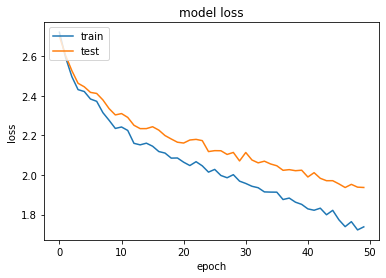

In [75]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#100 epoch
# accuracy: .8620, 38.88
# 0.7935, loss:1.88, 41.94

In [ ]:
# 50 epoch
# val_accuracy = .3972 mfcc
      # .3722 mfcc
# val_accuracy = 0.2139 chroma
# val_accuracy = 0.0639 mfcc + chroma
# 50 epoch - changed random_state
# val_accuracy

In [ ]:
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))

In [ ]:
X = df_piczak.drop(['esc'],axis=1)
Y = df_piczak['esc']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
# ranfom forest on MFCC features
rfc_mfcc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,n_jobs=-1, random_state=42)
rfc_mfcc.fit(X_train,Y_train)

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score




In [ ]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=216,epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
#DataFlair - Calculate the accuracy of our model
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

## RFC

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
from sklearn import model_selection
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring=’roc_auc’)


In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

In [ ]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = audio_test_files

train_data = train_data['fname'].apply(get_mfcc, path='../input/audio_train/')
print('done loading train mfcc')
test_data = test_data['fname'].apply(get_mfcc, path='../input/audio_test/')
print('done loading test mfcc')

train_data['label'] = train['label']
test_data['label'] = np.zeros((len(audio_test_files)))